## 1. Packages & Parallel Processing Setup 

In [27]:
# Initialize Distributed Workers
using Distributed
if nworkers() == 1
    addprocs(10)
end
nworkers()
using Plots
using LaTeXStrings
@everywhere begin
    using Agents
    using Random, Statistics
    using ProgressMeter
end
default(fmt=:png, dpi=300) # Set default plot format and resolution

## 2. Agent definition

In [28]:
# Define Opinion Agent
# Multi-opinion agent state: opinion vector xi of length K with entries in [-1, 1] 
@everywhere begin
    @agent struct OP(GridAgent{2})
        opinions::Vector{Float64}
    end
end

## 3. Helper - polarization - extremism metrics

In [29]:
# Define Polarization and Extremism Metrics
@everywhere begin
    trait_distance(op1::Vector{Float64}, op2::Vector{Float64}) = mean(abs.(op1 .- op2)) # Average absolute difference across all opinion dimensions

    function polarization(model) # Variance of pairwise opinion distances
        distances = Float64[]
        agents = collect(allagents(model))
        n = length(agents)
        for i in 1:(n-1), j in (i+1):n
            push!(distances, trait_distance(agents[i].opinions, agents[j].opinions)) # Compute and store distance
        end
        return var(distances) # Return variance of distances
    end

    function extremism(model)
        total = 0
        hits = 0
        for a in allagents(model), x in a.opinions
            total += 1
            hits += (abs(x) > 0.9) #Extremism set at |x| > 0.9, can adjust as needed
        end
        return hits / total # Return proportion of extreme opinions
    end
end


## 4. Model initialization

In [30]:
# Initialize Model
@everywhere begin
    function initialize(; M=50, local_int=false, num_opinions=2)
        space = GridSpaceSingle((M, M); periodic=true, metric=:manhattan)
        props = Dict(
            :local_int => local_int,
            :num_opinions => num_opinions,
            :polarization => 0.0,
            :extremism => 0.0,
        )
        model = StandardABM(OP, space; agent_step!, properties=props,
            scheduler=Schedulers.Randomly())
        for _ in 1:M^2 # Fill grid with agents
            add_agent_single!(model; opinions=(2 .* rand(num_opinions) .- 1)) # Random opinions in [-1, 1]
        end
        model.polarization = polarization(model) # Initial polarization
        model.extremism = extremism(model) # Initial extremism
        return model
    end
end


## 5. Dynamics - agent_step!

In [31]:
@everywhere begin
    function agent_step!(agent::OP, model)
        person_one = agent

        # Choose partner
        person_two = if model.local_int # Local interaction: pick random nearby agent 
            model[random_nearby_id(person_one, model, 1)]
        else
            random_agent(model, a -> a.id != person_one.id; optimistic=true, alloc=false) # Global interaction: pick random agent from entire population
        end
        person_two === nothing && return


        # Compute trait distance D and similarity weight w = 1 - D
        op1, op2 = person_one.opinions, person_two.opinions
        total = 0.0
        @inbounds for t in eachindex(op1)
            total += abs(op1[t] - op2[t])
        end
        dist = total / length(op1)
        weight = 1 - dist

        # Update opinions with weighted influence, scaled by (1 - abs(x)) to reduce influence as opinions become more extreme
        @inbounds for t in eachindex(op1)
            x1, x2 = op1[t], op2[t]
            op1[t] = x1 + 0.5 * weight * (x2 - x1) * (1 - abs(x1))
            op2[t] = x2 + 0.5 * weight * (x1 - x2) * (1 - abs(x2))
        end

        return
    end

    runmod(model; steps) = step!(model, steps)
end


## 6.  Helper - running simulation batches

In [32]:
# Run Trials Function
@everywhere begin
    function run_trial(num_ops; M=40, steps=3000, local_int=false)
        m = initialize(M=M, local_int=local_int, num_opinions=num_ops)
        runmod(m; steps)
        return polarization(m), extremism(m)
    end

    function run_trials(num_ops; n_trials=10, M=20, steps=3000, local_int=false)
        pe = zeros(n_trials, 2)
        for k in 1:n_trials
            pol, ext = run_trial(num_ops; M=M, steps=steps, local_int=local_int)
            pe[k, 1] = pol
            pe[k, 2] = ext
        end
        μ = vec(mean(pe, dims=1)) # Mean polarization and extremism across trials
        return pe, μ
    end
end


## 7. Helper - sweep number of opinions (K) and plot - Figure 5.10

In [33]:
# Sweep Number of Opinions for Both Interaction Types
function sweep_num_ops!(;
    K_range=1:10,
    steps=3000,
    n_trials_well=200,
    n_trials_local=200,
    M_well=40,
    M_local=40
)
    Ks = collect(K_range) # Number of opinion dimensions to sweep
    nK = length(Ks) # Number of K values

    mean_false = zeros(nK, 2) # Results for well-mixed interactions
    mean_true = zeros(nK, 2) # Results for local interactions
    raw_false = Vector{Matrix{Float64}}(undef, nK) # Raw trial results
    raw_true = Vector{Matrix{Float64}}(undef, nK) # Raw trial results


    combos_false = [(i, K) for (i, K) in enumerate(Ks)] # Well-mixed interaction combos
    combos_true = [(i, K) for (i, K) in enumerate(Ks)] # Local interaction combos

    p = Progress(length(combos_false) + length(combos_true); dt=0.1, desc="Sweeping K: global + local") # Progress bar
    ch = RemoteChannel(() -> Channel{Nothing}(1024)) # Channel for progress updates
    @async for _ in ch
        next!(p)
    end

    # Run trials in parallel for both interaction types
    res_false = pmap(combos_false) do (i, K)
        raw, μ = run_trials(K; n_trials=n_trials_well, M=M_well, steps=steps, local_int=false)
        remotecall_fetch(() -> put!(ch, nothing), 1)
        (i, μ, raw)
    end

    res_true = pmap(combos_true) do (i, K)
        raw, μ = run_trials(K; n_trials=n_trials_local, M=M_local, steps=steps, local_int=true)
        remotecall_fetch(() -> put!(ch, nothing), 1)
        (i, μ, raw)
    end

    close(ch)
    finish!(p)

    # Organize Results
    for (i, μ, raw) in res_false
        mean_false[i, :] = μ
        raw_false[i] = raw
    end
    for (i, μ, raw) in res_true
        mean_true[i, :] = μ
        raw_true[i] = raw
    end

    # Plotting Results

    # Well-mixed
    plt1 = plot(;
        xticks=Ks,
        xlabel=L"K",
        ylabel="Value",
        title="Polarization and Extremism vs K (Well Mixed)",
        legend=:topright,
        lw=2,
        grid=true,
    )
    for (i, K) in enumerate(Ks) # Loop over K values to add scatter points
        scatter!(fill(K, size(raw_false[i], 1)), raw_false[i][:, 1]; color=:blue, alpha=0.12, ms=3, label=false) # Polarization
        scatter!(fill(K, size(raw_false[i], 1)), raw_false[i][:, 2]; color=:red, alpha=0.12, ms=3, label=false) # Extremism
    end
    plot!(Ks, mean_false[:, 1]; lw=3, color=:blue, label="Polarization")
    plot!(Ks, mean_false[:, 2]; lw=3, color=:red, label="Extremism")
    display(plt1)

    # Local
    plt2 = plot(;
        xticks=Ks,
        xlabel=L"K",
        ylabel="Polarization / Extremism",
        title="Polarization and Extremism vs K (Local)",
        legend=:topright,
        lw=2,
        grid=true,
    )
    for (i, K) in enumerate(Ks) # Loop over K values to add scatter points
        scatter!(fill(K, size(raw_true[i], 1)), raw_true[i][:, 1]; color=:blue, alpha=0.12, ms=3, label=false) # Polarization
        scatter!(fill(K, size(raw_true[i], 1)), raw_true[i][:, 2]; color=:red, alpha=0.12, ms=3, label=false) # Extremism
    end
    plot!(Ks, mean_true[:, 1]; lw=3, color=:blue, label="Polarization")
    plot!(Ks, mean_true[:, 2]; lw=3, color=:red, label="Extremism")
    display(plt2)
end


sweep_num_ops! (generic function with 1 method)

## 8. Simulate and display plots

Sweeping K: global + local 100%|█████████████████████████| Time: 0:00:27


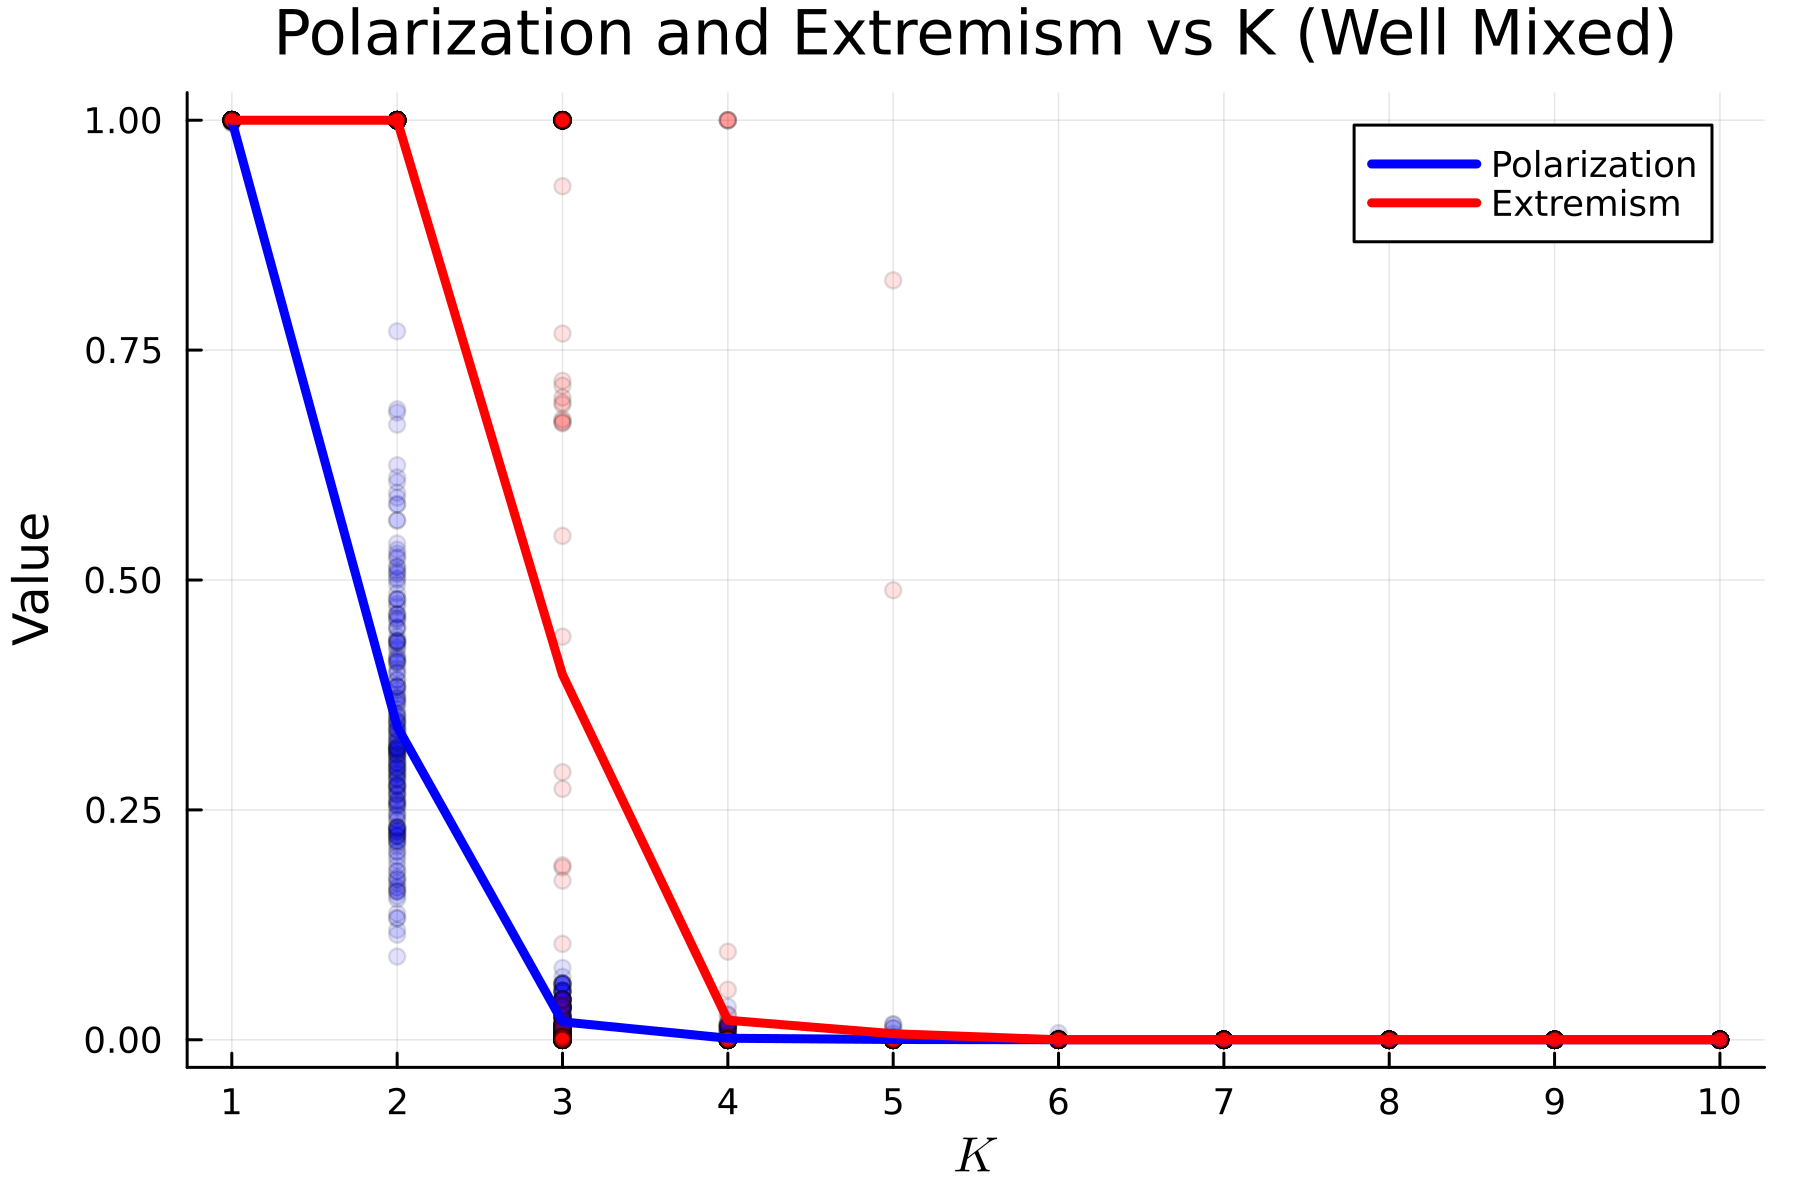

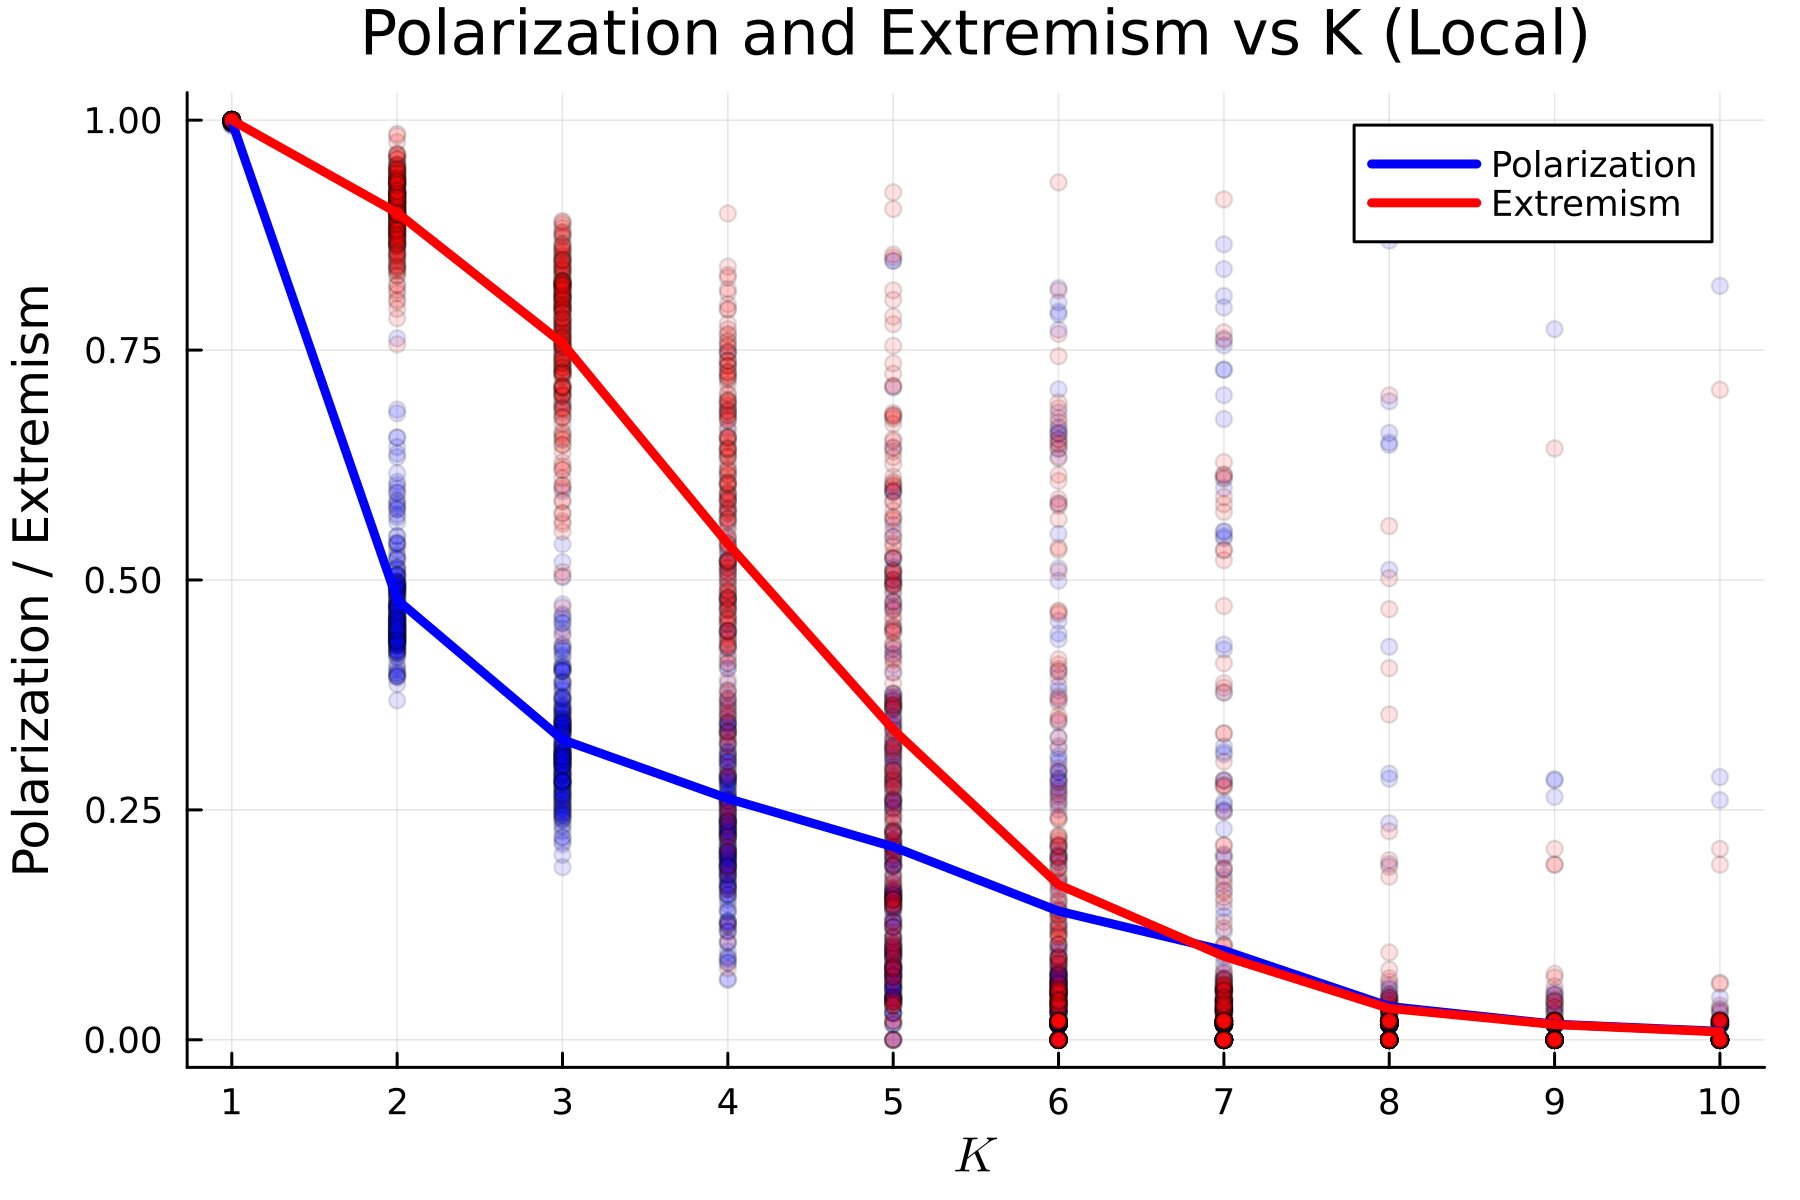

In [ ]:
# Run the Sweep and plot - adjust parameters as needed
out = sweep_num_ops!(;
    K_range=1:10,
    steps=1000,
    n_trials_well=200,
    n_trials_local=200,
    M_well=21,
    M_local=21
)
